<a href="https://colab.research.google.com/github/fm6224/RAG-Hybrid-Search/blob/main/RAG_Hybrid_Search_Reranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:
[Optimizing RAG with Hybrid Search & Reranking](https://superlinked.com/vectorhub/articles/optimizing-rag-with-hybrid-search-reranking)


In [1]:
# Step 1: Download the requirements.txt file from GitHub
!wget -O requirements.txt https://raw.githubusercontent.com/fm6224/RAG-Hybrid-Search/refs/heads/main/requirements.txt

--2024-11-22 17:55:23--  https://raw.githubusercontent.com/fm6224/RAG-Hybrid-Search/refs/heads/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3907 (3.8K) [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]   3.82K  --.-KB/s    in 0s      

2024-11-22 17:55:23 (61.4 MB/s) - ‘requirements.txt’ saved [3907/3907]



In [31]:
!pip install -qU "langchain-chroma>=0.1.2"
!pip install -qU langchain-huggingface

In [1]:
!pip install langchain langchain-community rank_bm25 pypdf unstructured chromadb
!pip install unstructured['pdf'] unstructured
!apt-get install poppler-utils
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev
!pip install pytesseract
!pip install bitsandbytes accelerate peft safetensors sentencepiece

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 0s (1,709 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.5_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.5) ...
Setting up poppler-utils (22.02.0-2ubuntu0.5) ...
Processing triggers for man-db (2.10.2-1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd

In [2]:
# Step 1: Create the 'content' folder
!mkdir -p content

# Step 2: Download the PDF file into the 'content' folder
!wget -O content/book.pdf "https://github.com/fm6224/RAG-Hybrid-Search/raw/main/algebra-for-machine-learning.pdf"

--2024-11-22 18:02:40--  https://github.com/fm6224/RAG-Hybrid-Search/raw/main/algebra-for-machine-learning.pdf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fm6224/RAG-Hybrid-Search/main/algebra-for-machine-learning.pdf [following]
--2024-11-22 18:02:40--  https://raw.githubusercontent.com/fm6224/RAG-Hybrid-Search/main/algebra-for-machine-learning.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1400200 (1.3M) [application/octet-stream]
Saving to: ‘content/book.pdf’

content/book.pdf    100%[===================>]   1.33M  --.-KB/s    in 0.04s   

2024-11-22 18:02:41 (37.8 MB/s) - ‘content/b

In [42]:
from langchain_community.document_loaders import UnstructuredPDFLoader
# from langchain.document_loaders import UnstructuredPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain.vectorstores import Chroma
from langchain_community.vectorstores import Chroma
# from langchain.embeddings import HuggingFaceInferenceAPIEmbeddings
from langchain_community.embeddings import HuggingFaceInferenceAPIEmbeddings
# from langchain.llms import HuggingFaceHub
from langchain_community.llms import HuggingFaceHub
import torch
from transformers import ( AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline, )
# from langchain import HuggingFacePipeline
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
# from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
import os, shutil


In [43]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
model_name = "BAAI/bge-large-en-v1.5"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings_model = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
    query_instruction="Generate a representation for this sentence for retrieving related articles:"
)
embeddings_model.query_instruction = "Generate a representation for this sentence for retrieving related articles:"


In [44]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings_model,
    persist_directory="./chroma_db",  # Where to save data locally, remove if not necessary
)

In [45]:
from uuid import uuid4

from langchain_core.documents import Document

document_1 = Document(
    page_content="I had chocolate chip pancakes and scrambled eggs for breakfast this morning.",
    metadata={"source": "tweet"},
    id=1,
)

document_2 = Document(
    page_content="The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.",
    metadata={"source": "news"},
    id=2,
)

document_3 = Document(
    page_content="Building an exciting new project with LangChain - come check it out!",
    metadata={"source": "tweet"},
    id=3,
)

document_4 = Document(
    page_content="Robbers broke into the city bank and stole $1 million in cash.",
    metadata={"source": "news"},
    id=4,
)

document_5 = Document(
    page_content="Wow! That was an amazing movie. I can't wait to see it again.",
    metadata={"source": "tweet"},
    id=5,
)

document_6 = Document(
    page_content="Is the new iPhone worth the price? Read this review to find out.",
    metadata={"source": "website"},
    id=6,
)

document_7 = Document(
    page_content="The top 10 soccer players in the world right now.",
    metadata={"source": "website"},
    id=7,
)

document_8 = Document(
    page_content="LangGraph is the best framework for building stateful, agentic applications!",
    metadata={"source": "tweet"},
    id=8,
)

document_9 = Document(
    page_content="The stock market is down 500 points today due to fears of a recession.",
    metadata={"source": "news"},
    id=9,
)

document_10 = Document(
    page_content="I have a bad feeling I am going to get deleted :(",
    metadata={"source": "tweet"},
    id=10,
)

documents = [
    document_1,
    document_2,
    document_3,
    document_4,
    document_5,
    document_6,
    document_7,
    document_8,
    document_9,
    document_10,
]
uuids = [str(uuid4()) for _ in range(len(documents))]

vector_store.add_documents(documents=documents, ids=uuids)

['1e67d440-ca70-4f6e-927d-64a76c406d57',
 '567a931a-5aa4-4982-ad53-9266892c027f',
 '1bef39a5-ecff-4e12-a74e-68f1caa748d1',
 '07645e4a-9db4-4c6e-8e95-419b1378a443',
 '9e84fc5e-5232-4c11-ab81-505201686869',
 'bbca977d-640b-4f49-a35d-9315030e2bb3',
 'b25dbe48-2f3b-493a-bd48-3f77db2f7b2a',
 '45669530-fed8-422e-be96-c9cf8ae53b6a',
 'ed182010-2c0b-4788-ac0b-f107b5347a4d',
 '413dd416-a8d2-42ac-b93d-03165e32833b']

In [46]:
results = vector_store.similarity_search(
    "LangChain provides abstractions to make working with LLMs easy",
    k=4,
    filter={"source": "tweet"},
)
for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

* Building an exciting new project with LangChain - come check it out! [{'source': 'tweet'}]
* LangGraph is the best framework for building stateful, agentic applications! [{'source': 'tweet'}]
* I have a bad feeling I am going to get deleted :( [{'source': 'tweet'}]
* Wow! That was an amazing movie. I can't wait to see it again. [{'source': 'tweet'}]


In [47]:
results = vector_store.similarity_search_with_score(
    "Will it be hot tomorrow?", k=1, filter={"source": "news"}
)
for res, score in results:
    print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]")

* [SIM=0.870645] The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees. [{'source': 'news'}]


In [49]:
results = vector_store.similarity_search_by_vector(
    embedding=embeddings_model.embed_query("I love green eggs and ham!"), k=1
)
for doc in results:
    print(f"* {doc.page_content} [{doc.metadata}]")

* I had chocolate chip pancakes and scrambled eggs for breakfast this morning. [{'source': 'tweet'}]


In [50]:
retriever = vector_store.as_retriever(
    search_type="mmr", search_kwargs={"k": 1, "fetch_k": 5}
)
retriever.invoke("Stealing from the bank is a crime", filter={"source": "news"})

[Document(metadata={'source': 'news'}, page_content='Robbers broke into the city bank and stole $1 million in cash.')]

# Work with Algebra books

In [54]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings_model,
    persist_directory="./algebra_for_ML_chroma_db",  # Where to save data locally, remove if not necessary
)

In [66]:
from uuid import uuid4
from langchain_core.documents import Document

DATA_PATH = "content/book.pdf"

# specify the path to the PDF document
doc_path = DATA_PATH
# create an instance of the UnstructuredPDFLoader class
file = UnstructuredPDFLoader(doc_path)
# load the PDF document into docs variable
docs = file.load()
# create chunks
# splitter = RecursiveCharacterTextSplitter(chunk_size=2500,
#                                           chunk_overlap=200)
# documents = splitter.split_documents(docs)

chunk_size = 512
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME),
    chunk_size=chunk_size,
    chunk_overlap=int(chunk_size/10),
)
documents = text_splitter.split_documents(docs)

In [67]:
print(len(documents))
print(documents[0].page_content)
print(documents[0].metadata)

234
Basics of Linear Algebra for Machine LearningDiscover the Mathematical Language of Data in PythonJason Brownlee

Disclaimer

The information contained within this eBook is strictly for educational purposes. If you wish to apply ideas contained in this eBook, you are taking full responsibility for your actions. The author has made every eﬀort to ensure the accuracy of the information within this book was correct at time of publication. The author does not assume and hereby disclaims any liability to any party for any loss, damage, or disruption caused by errors or omissions, whether such errors or omissions result from accident, negligence, or any other cause. No part of this eBook may be reproduced or transmitted in any form or by any means, electronic or mechanical, recording or by any information storage and retrieval system, without written permission from the author.

Acknowledgements

Special thanks to my copy editor Sarah Martin and my technical editors Arun Koshy and Andrei 

Model's maximum sequence length: 512


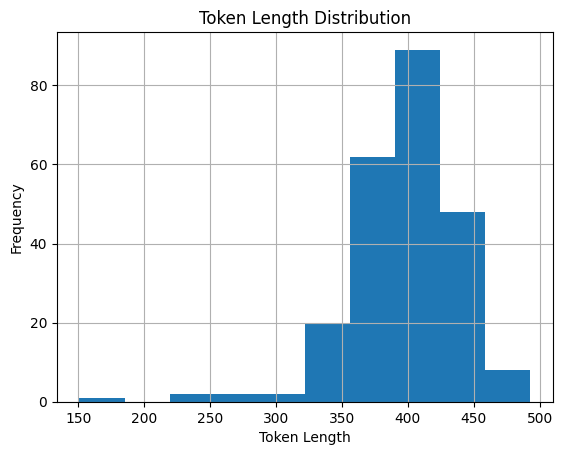

In [69]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import pandas as pd
from sentence_transformers import SentenceTransformer

EMBEDDING_MODEL_NAME = 'BAAI/bge-base-en-v1.5'
print(f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}")


# take chunks and model names as parameters
def plot_docs_tokens(docs_processed, EMBEDDING_MODEL_NAME):
  tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
  lengths = [len(tokenizer.encode(doc.page_content)) for doc in docs_processed]
  fig = pd.Series(lengths).hist()
  plt.xlabel("Token Length")
  plt.ylabel("Frequency")
  plt.title("Token Length Distribution")
  plt.show()

plot_docs_tokens(documents, EMBEDDING_MODEL_NAME)

In [70]:
uuids = [str(uuid4()) for _ in range(len(documents))]

vector_store.add_documents(documents=documents, ids=uuids)

['96d27de4-f1d0-4d5f-98f7-d75a62901b4d',
 '52728565-f9b7-4c36-9a34-beb2376f1472',
 '280b4997-2cde-4ee2-9251-8a665dc33e55',
 '97a4d0c7-760a-42e8-bbe1-faf9bed141d8',
 '60d225d2-ae78-41ca-b6ae-53a46ffab50f',
 '8476c70d-37f7-40df-8300-dd2f38b04a48',
 '70825aae-f12a-4f4a-a233-b16b9d50e490',
 '5f9d77d3-ed01-4dc5-9030-751571931a63',
 '68d9452e-ee5b-4b6f-9dde-8fd1d0c343b1',
 '58bafd5e-1431-4142-86a8-32f0870edf44',
 'e89ac6bc-8faf-4e03-8178-42476ed07321',
 '8dfc424c-d3df-4c01-a045-4d3a0b6a2a13',
 '722ae197-aad7-47e8-98c3-7cb134c99a29',
 '4025c31c-0a04-4d19-92a1-3ee48304d108',
 'f2a07fbc-3d05-43ad-8ea3-fc087da2d3e6',
 '8a6b0abb-c814-483a-b46c-ef737242c5f2',
 'a2cb21a0-9b51-4c51-a626-162566586605',
 'cd4579c9-be61-4e2c-afec-3629e90d2ea2',
 'fa822ec8-8efb-435f-8d3b-c1d1980ee6c5',
 '55a0b100-d6bc-4ff5-82fa-027aacb82ad1',
 'f4c3d0de-674a-485a-9803-05eb5263de6b',
 'd1294c99-1f8e-4b9d-91bd-79d0bede6e9c',
 '2d733ad9-1473-4628-9027-93c7124de2e8',
 'ca45c5f2-38c6-41bf-900d-6ef44eb1fe12',
 'c9e8e2f6-1618-

In [72]:
vectorstore_retriever = vector_store.as_retriever(search_kwargs={"k": 3})
keyword_retriever = BM25Retriever.from_documents(documents)
keyword_retriever.k =  3

In [74]:
ensemble_retriever = EnsembleRetriever(retrievers=[vectorstore_retriever,
                                                   keyword_retriever],
                                       weights=[0.3, 0.7])

In [78]:
model_name = "HuggingFaceH4/zephyr-7b-beta"

# function for loading 4-bit quantized model
def load_quantized_model(model_name: str):
    """
    model_name: Name or path of the model to be loaded.
    return: Loaded quantized model.
    """
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        # load_in_4bit=True,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config,
    )
    return model


In [79]:
# initializing tokenizer
def initialize_tokenizer(model_name: str):
    """
    model_name: Name or path of the model for tokenizer initialization.
    return: Initialized tokenizer.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name, return_token_type_ids=False)
    tokenizer.bos_token_id = 1  # Set beginning of sentence token id
    return tokenizer

tokenizer = initialize_tokenizer(model_name)

model = load_quantized_model(model_name)
# specify stop token ids
stop_token_ids = [0]

# build huggingface pipeline for using zephyr-7b-beta
pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    use_cache=True,
    device_map="auto",
    max_length=2048,
    do_sample=True,
    top_k=5,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

llm = HuggingFacePipeline(pipeline=pipeline)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

<ipython-input-79-1f00ca0dc1a4>:32: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipeline)


In [89]:
from langchain.chains import RetrievalQA

normal_chain = RetrievalQA.from_chain_type(
    llm=llm, chain_type="stuff", retriever=vectorstore_retriever
)

hybrid_chain = RetrievalQA.from_chain_type(
    llm=llm, chain_type="stuff", retriever=ensemble_retriever
)
response = normal_chain.invoke("QUERY")

In [87]:
# keyword search
from langchain import hub
from langchain.chains import RetrievalQA

# See full prompt at https://smith.langchain.com/hub/rlm/rag-prompt
prompt = hub.pull("rlm/rag-prompt")

qa_chain = RetrievalQA.from_llm(
    llm, retriever=vector_store.as_retriever(), prompt=prompt
)

qa_chain("Who can use this book?")


/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


{'query': 'Who can use this book?',
 'result': "Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: Who can use this book? \nContext: Context:\nEdition: v1.1\n\ni\n\nContents\n\nCopyright\n\nContents\n\nPreface\n\nI\n\nIntroduction\n\nWelcome\n\nvi vi Who Is This Book For? . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . About Your Outcomes . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . vi How to Read This Book . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . vii About the Book Structure . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . vii About Python Code Examples . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . viii ix About Further Reading . . . . . . . . . . . . . . . . . . . . . . . . . .

In [82]:
query = "What are the two strategic challenges that the United States faces according to the National Security Strategy?"

In [84]:
print("Semantic Search")
response = normal_chain.invoke(query)
print("Hybrid Search")
response = hybrid_chain.invoke(query)

Semantic Search
Hybrid Search


ValueError: Input length of input_ids is 2048, but `max_length` is set to 2048. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.